# Цель

Выбрать любой датасет для задачи бинарной классификации. Построить SVM и выборать оптимальное ядро.

# Выбор датасета

Наборы данных содержат транзакции, совершенные с помощью кредитных карт в сентябре 2013 года европейскими держателями карт. В этом наборе данных представлены транзакции, которые произошли за два дня, и у нас 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничество) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем конфиденциальности мы не можем предоставить оригинальные функции и дополнительную справочную информацию о данных. Функции V1, V2, ... V28 являются основными компонентами, полученными с помощью PCA, единственными функциями, которые не были преобразованы с помощью PCA, являются «Время» и «Сумма». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Сумма» - это сумма транзакции, эта функция может использоваться для примера, зависящего от стоимости обучения. Функция «Класс» - это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
import time
import re
# from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR

import xgboost as xgb
# import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# EDA

In [17]:
df = pd.read_csv('data/creditcard.csv')

## 1. Анализ целевой переменной

Class 0: 284315
Class 1: 492
Proportion: 577.88 : 1


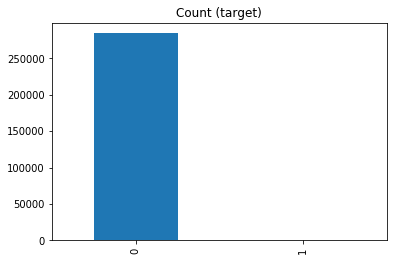

In [3]:
target_count = df['Class'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Датасет имеет очень высокий дизбаланс по значению целевой переменной `1`. При обучении необходимо проводить `undersampling`.

## 2. Анализ признаков

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

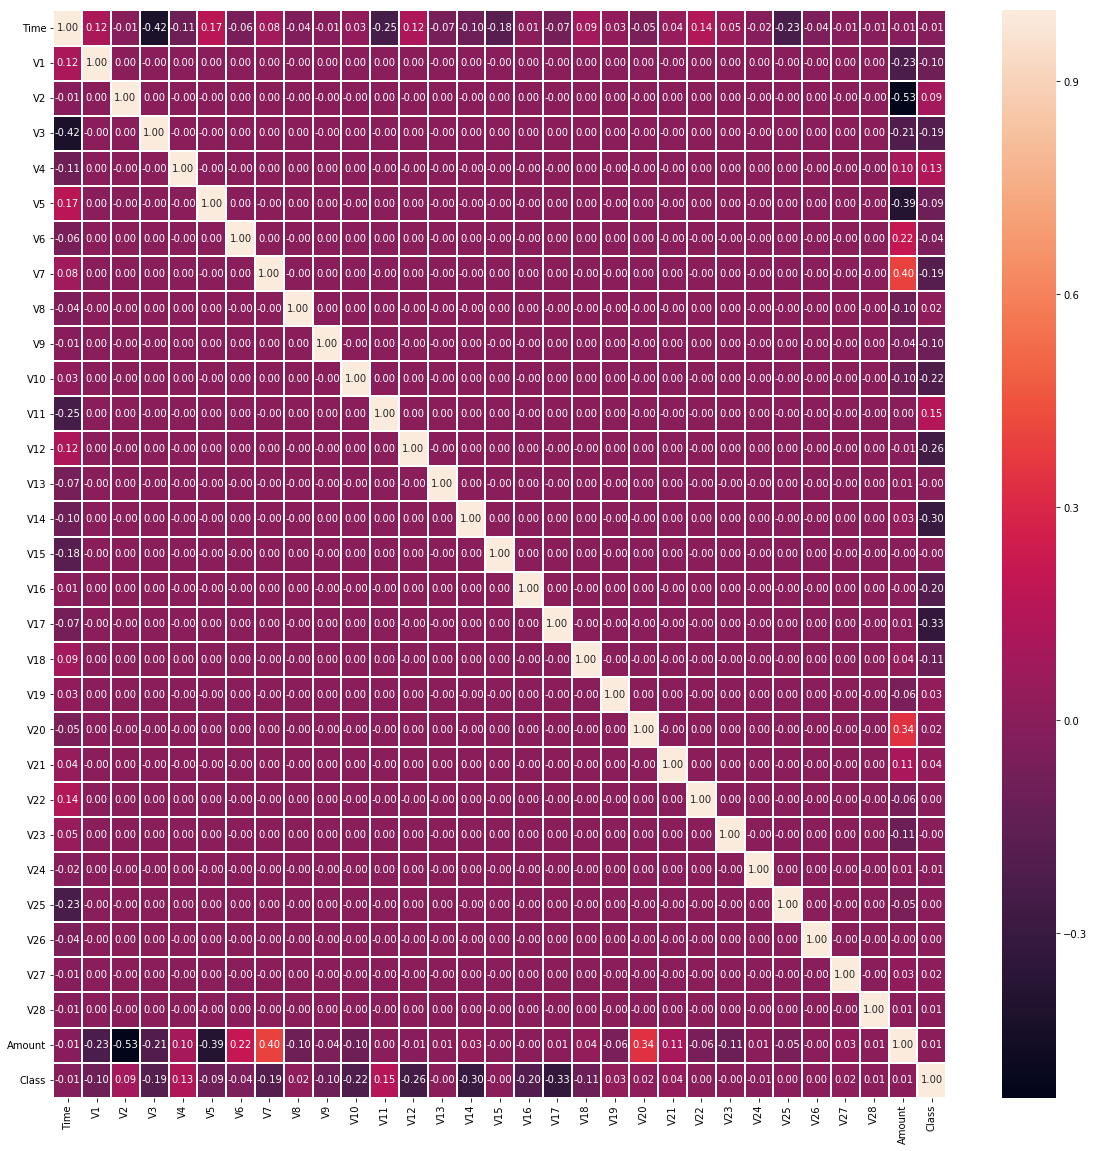

In [5]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2f',ax=ax);

Корреляция между признаками и целевой переменной отсутствует.

# 3. Выбор метрик

Посмотрим какую метрику рекомендует нам постановщики задачи:
```
Учитывая коэффициент дисбаланса класса (578/1), мы рекомендуем измерять точность, используя Area Under the Precision-Recall Curve (AUPRC). Точность (accuracy) Confusion matrix безсмысленна для несбалансированной классификации.
```

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from inspect import signature

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    
    


def plot_pr_curve(y_test, y_score):
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()
    
def plot_confusion_matrix(y_test, y_score):
    cm = confusion_matrix(y_test, y_score)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

# 4. Построение классификатора SVM

Разделим наш датасет в соотвествии с пропорцией целевой переменной.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Class'], axis=1), 
    df['Class'], 
    test_size=0.20, 
    random_state=42, 
    stratify=df['Class']
)

Выведем пропорцию.

In [8]:
train_target_count = y_train.value_counts()
print('Train Class 0:', train_target_count[0])
print('Train Class 1:', train_target_count[1])
print('Train Proportion:', round(train_target_count[0] / train_target_count[1], 2), ': 1')

test_target_count = y_test.value_counts()
print('\nTest Class 0:', test_target_count[0])
print('Test Class 1:', test_target_count[1])
print('Test Proportion:', round(test_target_count[0] / test_target_count[1], 2), ': 1')

Train Class 0: 227451
Train Class 1: 394
Train Proportion: 577.29 : 1

Test Class 0: 56864
Test Class 1: 98
Test Proportion: 580.24 : 1


## 4.1 Шкалирование

Объявим и обучим шкалировщик

In [36]:
ss = StandardScaler().fit(X_train)
X_train_scale = ss.transform(X_train)
X_test_scale = ss.transform(X_test)

## 4.2 Undersampling

Для дальнейшей работы с датасетом тренировочную выборку необходимо сбаланисировать. В виду малого количества искомых значений будем применять `undersampling`.

In [16]:
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, ClusterCentroids

Using TensorFlow backend.


Выведем размер текущей выборки.

In [17]:
print('Размер Х:',len(X_train))
print('Размер y:',len(y_train))
X_train.shape

Размер Х: 227845
Размер y: 227845


(227845, 30)

Объявим `ClusterCentroids` для undersampling'a.

In [18]:
%%time
cn = ClusterCentroids(random_state=42)
X_train_resample, y_train_resample = cn.fit_resample(X_train, y_train)

CPU times: user 13min 2s, sys: 7min 8s, total: 20min 10s
Wall time: 21min


Сохраним результат преобразований признаков в файл, для возможности последующего чтения.

In [3]:
# pd.DataFrame(X_train_resample).to_csv("data/X_train_resample.csv")
X_train_resample = pd.read_csv('data/X_train_resample.csv',index_col=0)
X_train_resample.head(5)

0     1     2     3     4     5     6     7     8     9  ...     20  \
0 160848.64  0.35  0.14 -0.77 -0.17  0.36 -0.19  0.08  0.02 -0.04  ...  -0.05   
1  57417.13 -0.26 -0.10  0.71  0.13 -0.31  0.07 -0.15  0.08 -0.21  ...  -0.06   
2  91512.48  0.34  0.21 -0.22  0.36  0.43 -0.01  0.01 -0.34  1.43  ...  -0.09   
3 125678.04  0.46 -0.06 -0.65 -0.18  0.42  0.02  0.10 -0.10 -0.07  ...  -0.12   
4  28191.88 -0.13  0.00  0.76 -0.03 -0.06  0.02 -0.08 -0.02 -0.28  ...   0.05   

     21    22    23    24    25    26    27    28    29  
0  0.04  0.09  0.05 -0.01 -0.14  0.02  0.01 -0.01 56.22  
1 -0.02 -0.11 -0.02  0.04  0.15  0.05 -0.03  0.02 84.38  
2  0.05  0.04  0.04  0.06 -0.16 -0.01  0.03 -0.01 67.92  
3  0.05  0.16  0.03 -0.04 -0.11 -0.05 -0.01  0.00 63.77  
4 -0.00 -0.04 -0.04  0.06  0.11  0.03 -0.03  0.00 63.11  

[5 rows x 30 columns]

Также созраним результат преобразования целевой переменной.

In [6]:
# pd.DataFrame(y_train_resample).to_csv("data/y_train_resample.csv")
y_train_resample = pd.read_csv('data/y_train_resample.csv',index_col=0)
y_train_resample.head(5)

0
0  0
1  0
2  0
3  0
4  0

Посмотрим на итоговый результат `undersampling'a`.

In [22]:
print('Размер Х:',len(X_train_resample))
print('Размер y:',len(y_train_resample))
X_train_resample.shape

Размер Х: 788
Размер y: 788


(788, 30)

Посмотрим итоговую пропорцию.

In [15]:
train_target_count = y_train_resample['0'].value_counts()
print('Train Class 0:', train_target_count[0])
print('Train Class 1:', train_target_count[1])
print('Train Proportion:', round(train_target_count[0] / train_target_count[1], 2), ': 1')

Train Class 0: 394
Train Class 1: 394
Train Proportion: 1.0 : 1


Баланс тренировочной выборки стал 1 к 1.

Выведем информацию во сколько раз наше выборка уменьшилась.

In [22]:
print("Выборка уменьшена в {}".format(X_train.shape[0]/X_train_resample.shape[0]))

Выборка уменьшена в 289.14340101522845


! Это очень негативный результат. Было потеряно большое количество данных. Посмотрим, что можно сделать из преобразованных данных.

Проведем шкалирование тренировочной и тестовой выборок.

In [23]:
X_train_resample_scale = ss.transform(X_train_resample)
X_test_scale = ss.transform(X_test)

Простроим график и посмотрим распределение признаков от целевой переменной.

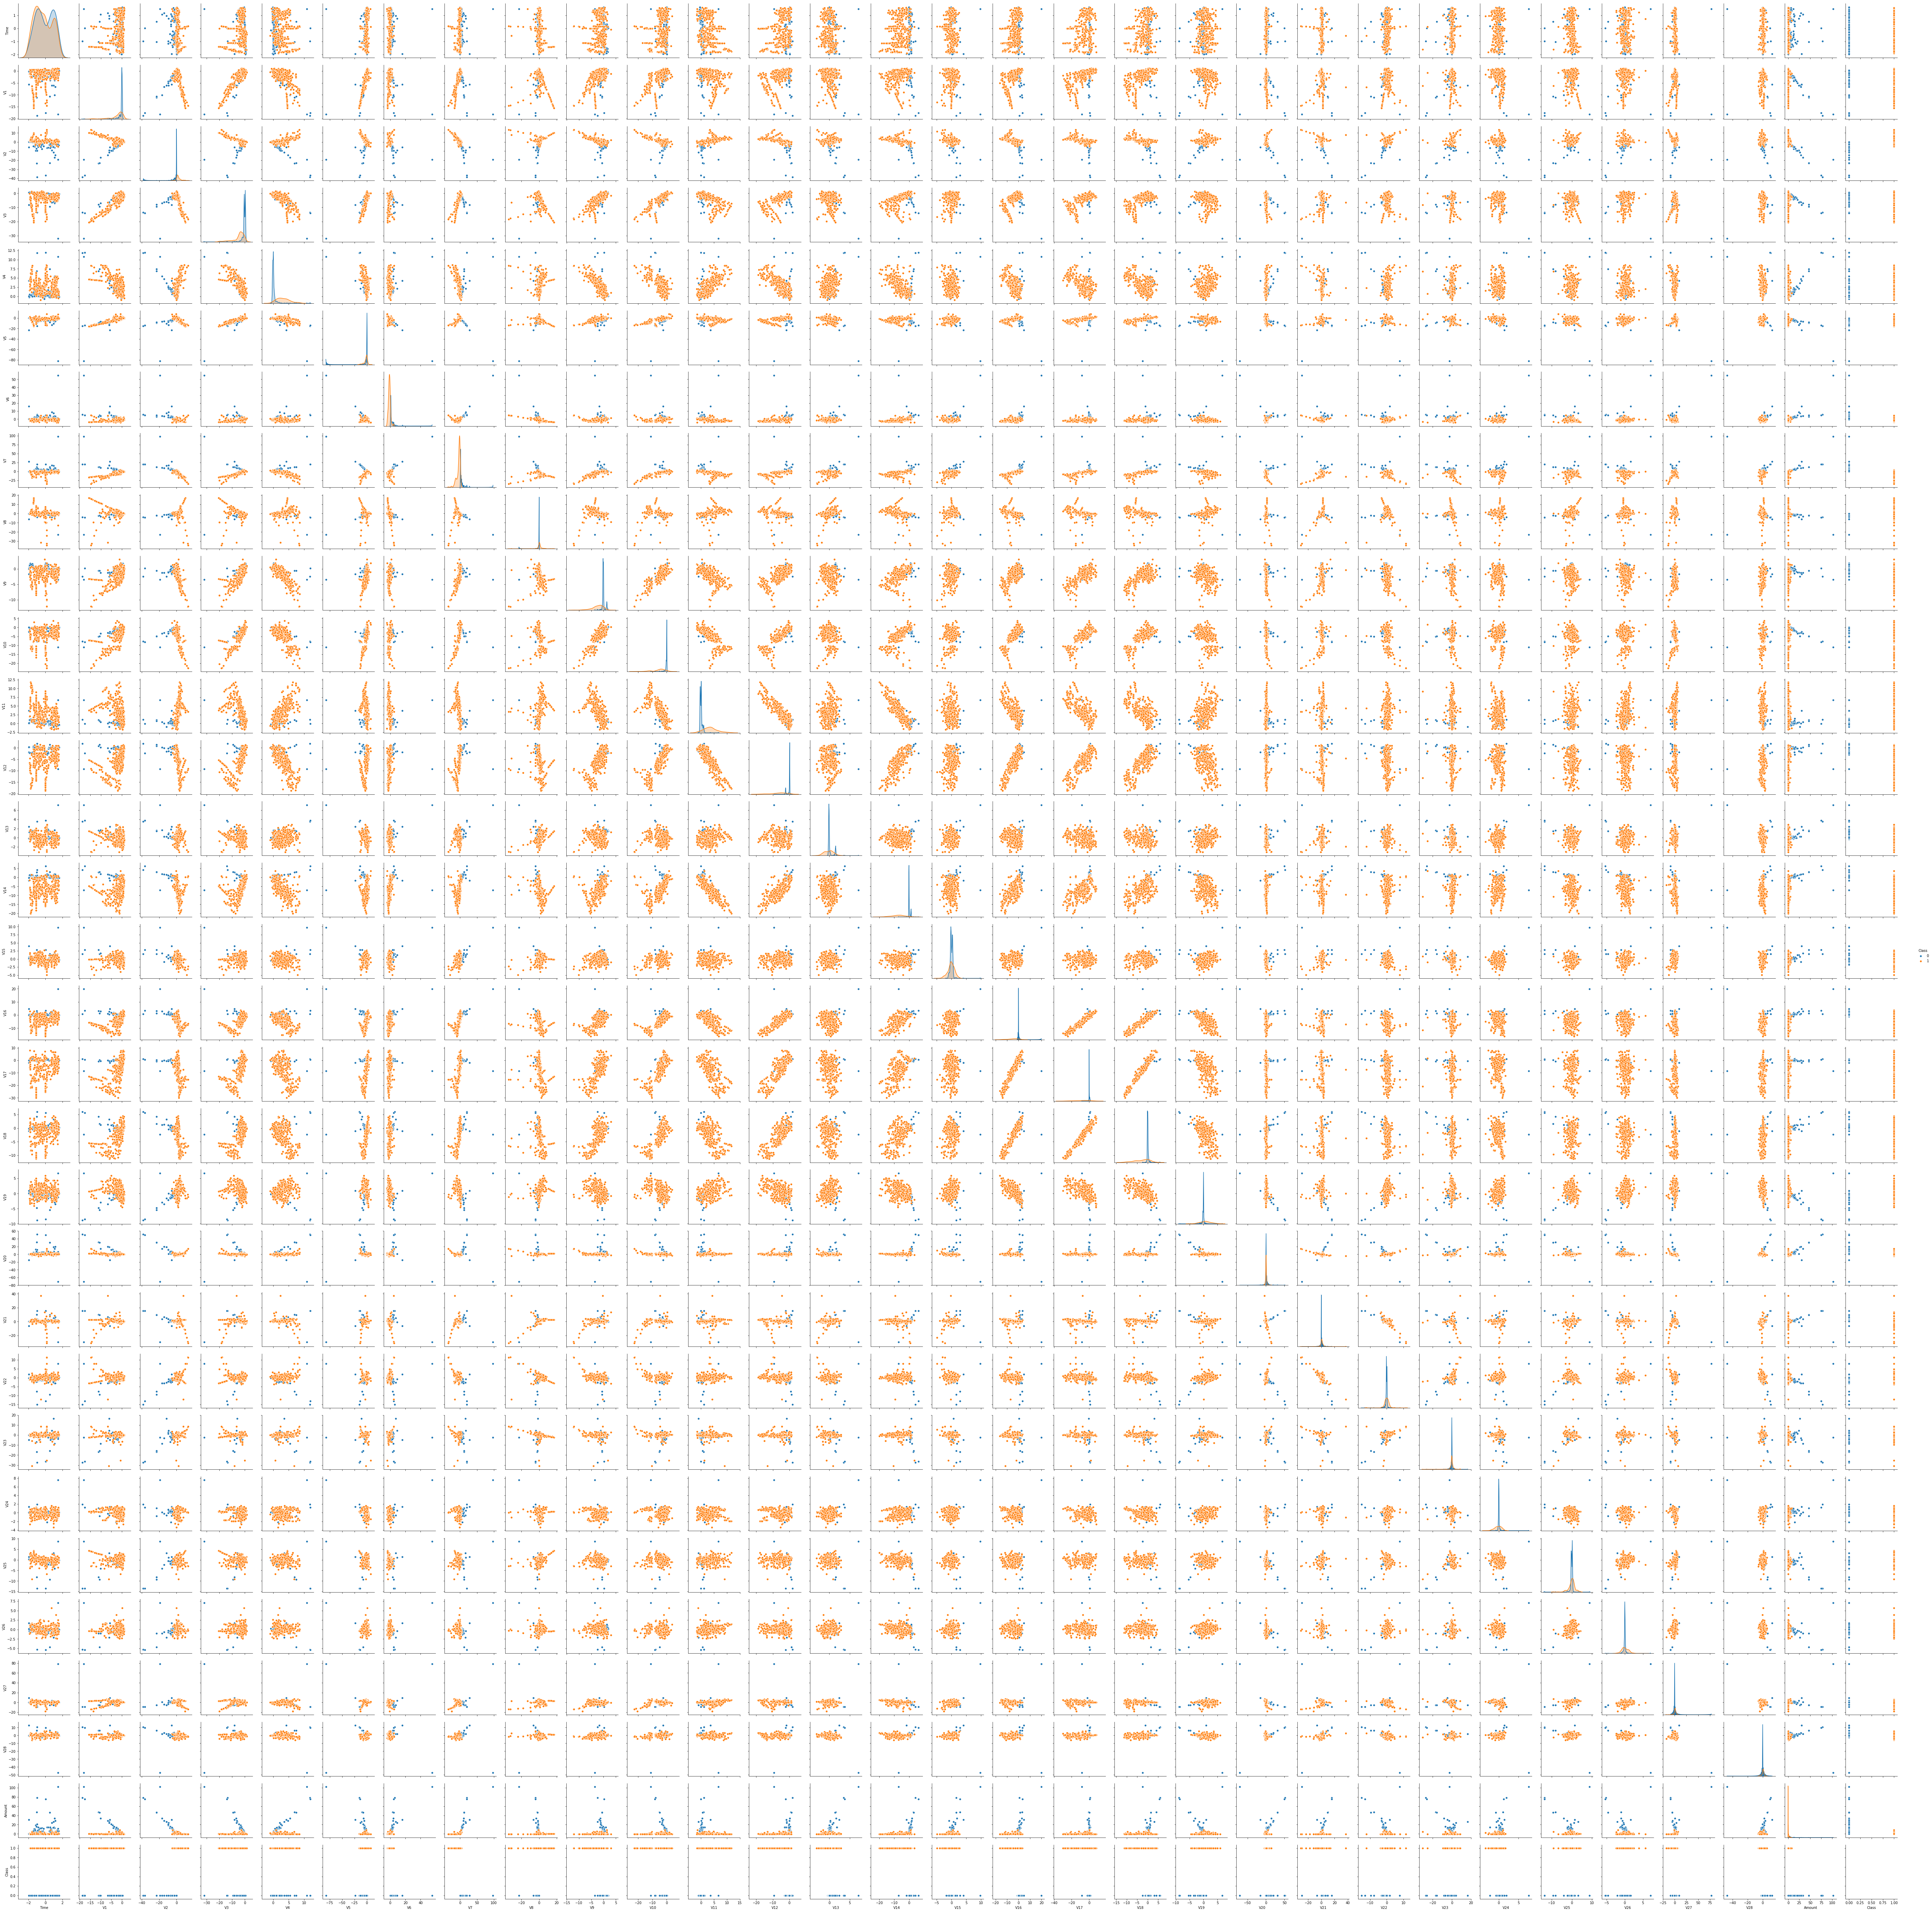

In [24]:
df_resample = pd.DataFrame(X_train_resample_scale, columns=X_train.columns)
df_resample['Class'] = y_train_resample

sns.pairplot(df_resample,hue='Class');

## 4.3 Baseline

In [26]:
y_naive = np.random.choice([0, 1], size=y_test.shape[0], p=y_train_resample['0'].value_counts(normalize=True))

Accuracy: 0.501
Precision: 0.582
Recall: 0.002
f1_score: 0.004
Average precision-recall score: 0.00


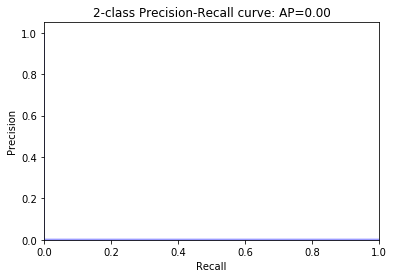

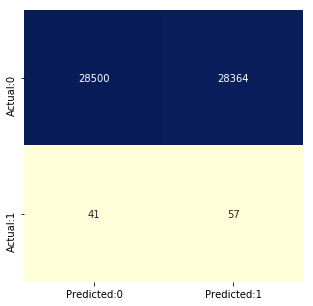

In [35]:
quality_report(y_naive, y_test)
plot_pr_curve(y_test, y_naive)
plot_confusion_matrix(y_test,y_naive)

Результаты базовой модели соответствуют вероятности 50%.

## 4.4 SVM

In [38]:
from sklearn.externals.joblib import Parallel, parallel_backend
from sklearn.externals.joblib import register_parallel_backend
from sklearn.externals.joblib import delayed
from sklearn.externals.joblib import cpu_count

from sklearn.svm import SVC # "Support vector classifier"

Построим SVM классификатор с линейным ядром на данных без `undersampling'a`.

In [ ]:
%%time

model_svc = SVC(kernel='linear')
with parallel_backend('threading'):
    model_svc.fit(X_train_scale, y_train) 

In [14]:
y_pred = model_svc.predict(X_test)

Посмотрим результаты предсказаний.

Accuracy: 0.998
Precision: 0.010
Recall: 1.000
f1_score: 0.020
Average precision-recall score: 0.01


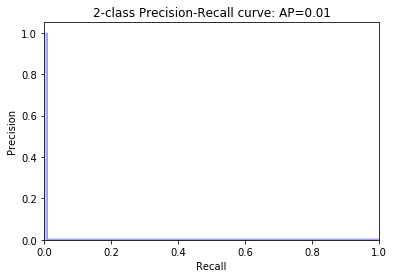

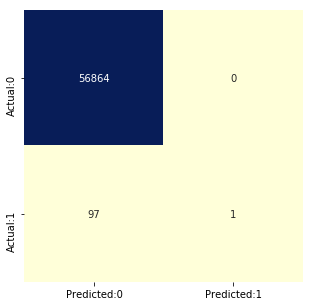

In [15]:
quality_report(y_pred, y_test)
plot_pr_curve(y_test, y_pred);
plot_confusion_matrix(y_test,y_pred);

Данная модель отлично предсказывает `класс 0`, но очень плохо `класс 1` целевой переменной.

Посмотрим предсказание на данных после `undersampling'a`.

In [25]:
%%time
model_resample_scale_svc = SVC(kernel='linear')
with parallel_backend('threading'):
    model_resample_scale_svc.fit(X_train_resample_scale, y_train_resample)

CPU times: user 16.7 ms, sys: 6.69 ms, total: 23.4 ms
Wall time: 19.9 ms


In [26]:
y_pred = model_resample_scale_svc.predict(X_test)

Accuracy: 0.002
Precision: 1.000
Recall: 0.002
f1_score: 0.003
Average precision-recall score: 0.00


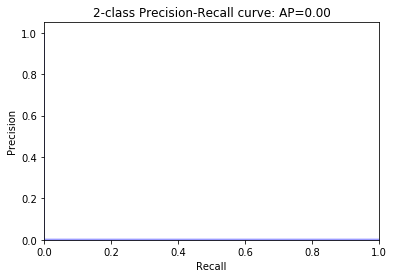

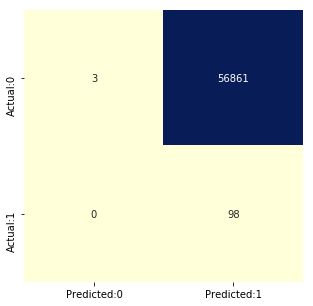

In [27]:
quality_report(y_pred, y_test)
plot_pr_curve(y_test, y_pred);
plot_confusion_matrix(y_test,y_pred);

Действительно, `undersampling` помог нам улучшить результат по предсказанию `класса 1`, но в то же время стал предсказывать плохо `класс 0`. Текущее соотношение по `классу 0` очень велико и данная модель нам не подходит.

## 4.5 Подбор гиперпараметров  SVM

Будем подбирать ядро и штраф CV.

In [31]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid')}
svc = SVC()
grid = GridSearchCV(svc, parameters, cv=5)
with parallel_backend('threading'):
    grid.fit(X_train_resample_scale, y_train_resample)
print('CV error = ', 1 - grid.best_score_)
best_estimator_kernel = grid.best_estimator_.kernel
print('best kernel  = ', best_estimator_kernel)

CV error    =  0.017766497461928932
best kernel  =  linear


Accuracy: 0.002
Precision: 1.000
Recall: 0.002
f1_score: 0.003


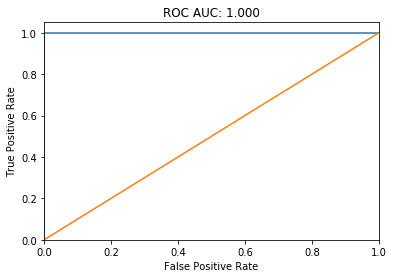

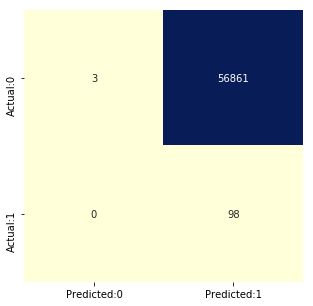

In [32]:
y_pred = grid.best_estimator_.predict(X_test)
quality_report(y_pred, y_test)
plot_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test,y_pred)

Результаты получились аналогичные предыдущей модели с линейным ядром. Также GridSearch показал, что линейное ядро наилучшее.

Подберем остальные параметры.

In [33]:
C_array = np.logspace(-3, 3, num=7)
gamma_array = np.logspace(-5, 2, num=8)
parameters = {'C':C_array, 'gamma':gamma_array}
svc = SVC(kernel=grid.best_estimator_.kernel)
grid = GridSearchCV(svc, parameters, cv=5)
with parallel_backend('threading'):
    grid.fit(X_train_resample_scale, y_train_resample)
print('CV error    = ', 1 - grid.best_score_)
best_estimator_C = grid.best_estimator_.C
best_estimator_gamma = grid.best_estimator_.gamma
print('best C      = ', best_estimator_C)
print('best gamma  = ', best_estimator_gamma)

CV error    =  0.017766497461928932
best C      =  1.0
best gamma  =  1e-05


In [34]:
clf = SVC(kernel=best_estimator_kernel, C=best_estimator_C, gamma=best_estimator_gamma)
with parallel_backend('threading'):
    clf.fit(X_train_resample_scale, y_train_resample) 

Accuracy: 0.002
Precision: 1.000
Recall: 0.002
f1_score: 0.003


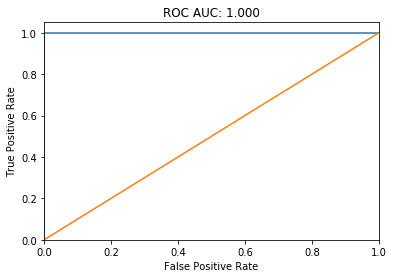

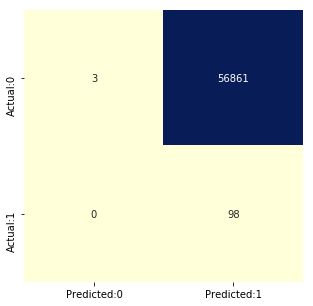

In [35]:
y_pred = clf.predict(X_test)
quality_report(y_pred, y_test)
plot_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test,y_pred)

Результаты подбора аналогичные.

## Выводы

В рамках поставленной задачи по применению SVM для бинарной классификации была построена SVM модель и подобраны ее гиперпараметры. К сожалению, достигнутый результат не удовлетворяет требованиям для классификации по точности и полноте.

Для данного датасета в виду его высокой несбалансированности стоит попробовать алгоритм решающего дерева.